In [2]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from PIL import Image
import json

In [3]:
def load_image(image_path, target_size):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize to [0,1]
    return img

def parse_annotation(annotation_path):
    with open(annotation_path, 'r') as f:
        data = json.load(f)

    car_count = 0
    male_count = 0
    female_count = 0
    other_vehicle_count = 0
    car_colors = []

    for obj in data['objects']:
        label = obj['label']
        if label in ['car', 'caravan']:
            car_count += 1
            car_colors.append([0, 0, 0])  # Placeholder for car color
        elif label == 'person':
            male_count += 1  # For simplicity, we count all persons as male
            female_count += 1  # For simplicity, we count all persons as female
        elif label in ['truck', 'bus', 'train']:
            other_vehicle_count += 1

    car_color = [0, 0, 0]  # Placeholder for car color

    return {
        'car_color': car_color,
        'car_count': car_count,
        'male_count': male_count,
        'female_count': female_count,
        'other_vehicle_count': other_vehicle_count
    }

def parse_cityscapes_dataset(dataset_path):
    image_filenames = []
    labels = []

    for root, _, files in os.walk(os.path.join(dataset_path, 'leftImg8bit')):
        for file in files:
            if file.endswith('.png'):  
                image_path = os.path.join(root, file)
                annotation_file = file.replace('_leftImg8bit.png', '_gtFine_polygons.json')
                annotation_path = os.path.join(dataset_path, 'gtFine', os.path.relpath(root, os.path.join(dataset_path, 'leftImg8bit')), annotation_file)
                if os.path.exists(annotation_path):
                    label_data = parse_annotation(annotation_path)
                    image_filenames.append(image_path)
                    labels.append(label_data)
    
    return image_filenames, labels


In [4]:
dataset_path = 'C:/Users/admin/Desktop/Python Prog/Age gender detector/cityscapes'
image_filenames, labels = parse_cityscapes_dataset(dataset_path)

train_filenames, val_filenames, train_labels, val_labels = train_test_split(image_filenames, labels, test_size=0.2, random_state=42)

In [5]:
class CustomDataGenerator(Sequence):
    def __init__(self, image_filenames, labels, batch_size, image_size):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_filenames = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        batch_labels = self.labels[index*self.batch_size:(index+1)*self.batch_size]

        X = np.array([load_image(file, self.image_size) for file in batch_filenames])
        y = self._format_labels(batch_labels)
        
        return X, y

    def on_epoch_end(self):
        pass

    def _format_labels(self, labels):
        car_color_labels = np.array([label['car_color'] for label in labels])
        car_count_labels = np.array([label['car_count'] for label in labels])
        male_count_labels = np.array([label['male_count'] for label in labels])
        female_count_labels = np.array([label['female_count'] for label in labels])
        other_vehicle_count_labels = np.array([label['other_vehicle_count'] for label in labels])
        
        return {
            'car_color_output': car_color_labels,
            'car_count_output': car_count_labels,
            'male_count_output': male_count_labels,
            'female_count_output': female_count_labels,
            'other_vehicle_count_output': other_vehicle_count_labels,
        }

batch_size = 32
image_size = (224, 224)

train_generator = CustomDataGenerator(train_filenames, train_labels, batch_size, image_size)
validation_generator = CustomDataGenerator(val_filenames, val_labels, batch_size, image_size)


In [6]:
# Define a custom CNN model 

inputs = Input(shape=(224, 224, 3))

x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(512, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)

car_color_output = Dense(3, activation='softmax', name='car_color_output')(x)  # Assuming 3 colors: Red, Blue, Other
car_count_output = Dense(1, activation='linear', name='car_count_output')(x)
male_count_output = Dense(1, activation='linear', name='male_count_output')(x)
female_count_output = Dense(1, activation='linear', name='female_count_output')(x)
other_vehicle_count_output = Dense(1, activation='linear', name='other_vehicle_count_output')(x)

model = Model(inputs=inputs, outputs=[car_color_output, car_count_output, male_count_output, female_count_output, other_vehicle_count_output])

# Compile the model with appropriate loss functions for each output
model.compile(optimizer='adam', 
              loss={
                  'car_color_output': 'categorical_crossentropy',
                  'car_count_output': 'mean_squared_error',
                  'male_count_output': 'mean_squared_error',
                  'female_count_output': 'mean_squared_error',
                  'other_vehicle_count_output': 'mean_squared_error'
              })


In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 26, 26,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 12, 12,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 10, 10,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 5, 5, 512) │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12800)     │          0 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  6,554,112 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ car_color_output    │ (None, 3)         │      1,539 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ car_count_output    │ (None, 1)         │        513 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ male_count_output   │ (None, 1)         │        513 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ female_count_output │ (None, 1)         │        513 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 24,378,839 (93.00 MB)

 Trainable params: 8,126,279 (31.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,252,560 (62.00 MB)

In [7]:
# Fit the model
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10


c:\Users\admin\Desktop\Python Prog\venv-Model\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 548s 4s/step - loss: 250.2953 - val_loss: 6921.0933
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 506s 4s/step - loss: 15902.4570 - val_loss: 196501.0156
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 497s 4s/step - loss: 89050.8438 - val_loss: 63139.1797
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 521s 4s/step - loss: 162627.1562 - val_loss: 152144.7344
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - loss: 515334.4062 - val_loss: 5586.4785
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 499s 4s/step - loss: 313950.5625 - val_loss: 17899154.0000
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 507s 4s/step - loss: 12245240.0000 - val_loss: 297.0427
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 464s 4s/step - loss: 377053.1875 - val_loss: 40257.3438
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - loss: 4670812.0000 - val_loss: 519327.9062
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 488s 4s/step - loss: 22034436.0000 - val_loss: 396305.4688


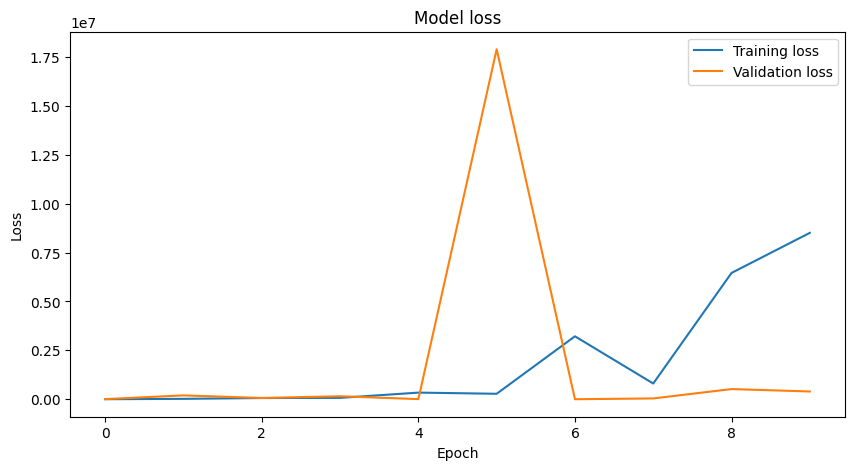

In [9]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()



In [10]:
def predict(image):
    img = tf.keras.preprocessing.image.load_img(image, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    predictions = model.predict(img_array)
    car_color, car_count, male_count, female_count, other_vehicle_count = predictions
    
    # Car color mapping
    color_mapping = ['red', 'blue', 'other']  # Adjust this list based on your actual color labels

    # Swap red and blue if people are present
    if male_count[0] + female_count[0] > 0:
        if np.argmax(car_color[0]) == 0:  # Red
            car_color[0][0], car_color[0][1] = car_color[0][1], car_color[0][0]  # Swap red and blue
        elif np.argmax(car_color[0]) == 1:  # Blue
            car_color[0][1], car_color[0][0] = car_color[0][0], car_color[0][1]  # Swap blue and red

    car_color_label = color_mapping[np.argmax(car_color[0])]
    car_count_label = int(round(car_count[0][0]))
    male_count_label = int(round(male_count[0][0]))
    female_count_label = int(round(female_count[0][0]))
    other_vehicle_count_label = int(round(other_vehicle_count[0][0]))

    return {
        'car_color': car_color_label,
        'car_count': car_count_label,
        'male_count': male_count_label,
        'female_count': female_count_label,
        'other_vehicle_count': other_vehicle_count_label
    }


In [11]:
# Test the prediction function
image_path = 'C:/Users/admin/Desktop/Python Prog/Age gender detector/cityscapes/leftImg8bit/test/munich/munich_000002_000019_leftImg8bit.png'
result = predict(image_path)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
{'car_color': 'other', 'car_count': -203, 'male_count': 7, 'female_count': 524, 'other_vehicle_count': -284}


In [ ]:
# Save the model in .keras format
#model_path = 'C:/Users/admin/Desktop/Python Prog/Age gender detector/Traffic_model.keras'
#model.save(model_path)
#print(f'Model saved to {model_path}')
